Loading data...
Preprocessing & Feature Engineering...
Training set shape: (1037340, 17)
Test set shape: (259335, 17)
Fraud ratio in Train: 0.5789%
Calculated scale_pos_weight: 171.75

HYPERPARAMETER TUNING WITH OPTUNA

[1/3] Tuning XGBoost...


  0%|          | 0/30 [00:00<?, ?it/s]


>>> Optimal Threshold Found: 0.8469
>>> Best F1-Score at threshold: 0.9036

>>> Optimal Threshold Found: 0.8053
>>> Best F1-Score at threshold: 0.9167

>>> Optimal Threshold Found: 0.7315
>>> Best F1-Score at threshold: 0.9104

>>> Optimal Threshold Found: 0.8886
>>> Best F1-Score at threshold: 0.8989

>>> Optimal Threshold Found: 0.9151
>>> Best F1-Score at threshold: 0.9123

>>> Optimal Threshold Found: 0.8934
>>> Best F1-Score at threshold: 0.9012

>>> Optimal Threshold Found: 0.9689
>>> Best F1-Score at threshold: 0.7273

>>> Optimal Threshold Found: 0.9503
>>> Best F1-Score at threshold: 0.7318

>>> Optimal Threshold Found: 0.9602
>>> Best F1-Score at threshold: 0.7337

>>> Optimal Threshold Found: 0.9690
>>> Best F1-Score at threshold: 0.8112

>>> Optimal Threshold Found: 0.9654
>>> Best F1-Score at threshold: 0.8231

>>> Optimal Threshold Found: 0.9644
>>> Best F1-Score at threshold: 0.8076

>>> Optimal Threshold Found: 0.9725
>>> Best F1-Score at threshold: 0.8071

>>> Optimal

  0%|          | 0/30 [00:00<?, ?it/s]


>>> Optimal Threshold Found: 1.0000
>>> Best F1-Score at threshold: 0.5178

>>> Optimal Threshold Found: 0.9847
>>> Best F1-Score at threshold: 0.5190

>>> Optimal Threshold Found: 0.9984
>>> Best F1-Score at threshold: 0.5560

>>> Optimal Threshold Found: 0.9861
>>> Best F1-Score at threshold: 0.3806

>>> Optimal Threshold Found: 1.0000
>>> Best F1-Score at threshold: 0.3956

>>> Optimal Threshold Found: 1.0000
>>> Best F1-Score at threshold: 0.0245

>>> Optimal Threshold Found: 0.9679
>>> Best F1-Score at threshold: 0.7878

>>> Optimal Threshold Found: 0.9674
>>> Best F1-Score at threshold: 0.8025

>>> Optimal Threshold Found: 0.9627
>>> Best F1-Score at threshold: 0.7943

>>> Optimal Threshold Found: 0.9587
>>> Best F1-Score at threshold: 0.8283

>>> Optimal Threshold Found: 0.9475
>>> Best F1-Score at threshold: 0.8487

>>> Optimal Threshold Found: 0.9509
>>> Best F1-Score at threshold: 0.8223

>>> Optimal Threshold Found: 0.9584
>>> Best F1-Score at threshold: 0.5591

>>> Optimal

  0%|          | 0/30 [00:00<?, ?it/s]


>>> Optimal Threshold Found: 0.9233
>>> Best F1-Score at threshold: 0.8869

>>> Optimal Threshold Found: 0.8967
>>> Best F1-Score at threshold: 0.8963

>>> Optimal Threshold Found: 0.9191
>>> Best F1-Score at threshold: 0.8796

>>> Optimal Threshold Found: 0.9708
>>> Best F1-Score at threshold: 0.7651

>>> Optimal Threshold Found: 0.9705
>>> Best F1-Score at threshold: 0.7646

>>> Optimal Threshold Found: 0.9683
>>> Best F1-Score at threshold: 0.7977

>>> Optimal Threshold Found: 0.9640
>>> Best F1-Score at threshold: 0.8700

>>> Optimal Threshold Found: 0.9703
>>> Best F1-Score at threshold: 0.8751

>>> Optimal Threshold Found: 0.9768
>>> Best F1-Score at threshold: 0.8534

>>> Optimal Threshold Found: 0.9602
>>> Best F1-Score at threshold: 0.7677

>>> Optimal Threshold Found: 0.9552
>>> Best F1-Score at threshold: 0.7935

>>> Optimal Threshold Found: 0.9555
>>> Best F1-Score at threshold: 0.7805

>>> Optimal Threshold Found: 0.9522
>>> Best F1-Score at threshold: 0.7586

>>> Optimal

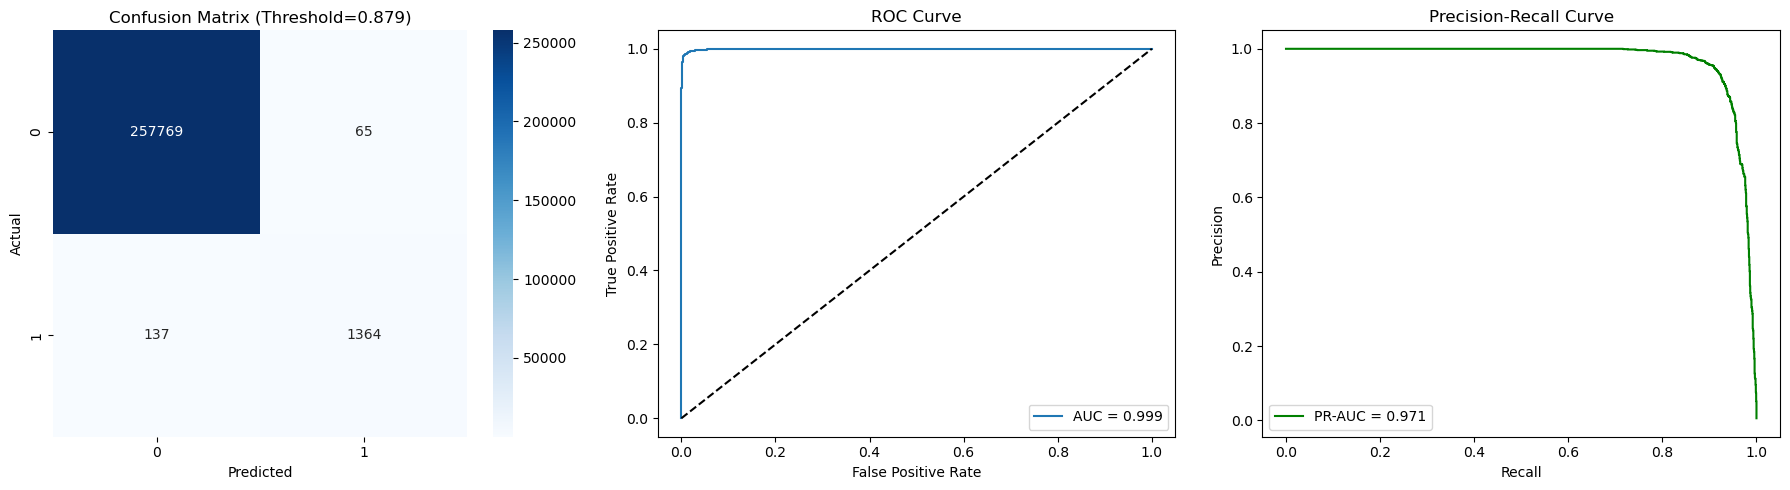


SAVING MODEL
Tuned model saved to: fraud_detection_model_tuned.pkl

TRAINING COMPLETED!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             roc_auc_score, precision_recall_curve, auc, 
                             confusion_matrix, classification_report)
from sklearn.ensemble import VotingClassifier

# Boosting Models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import joblib

# Hyperparameter Tuning
import optuna
from optuna.samplers import TPESampler

warnings.filterwarnings('ignore')

# ============================================================================
# 1. ADVANCED FEATURE ENGINEERING
# ============================================================================

def create_features(df):
    """
    Tạo các features tập trung vào sự bất thường trong hành vi tiêu dùng
    """
    df = df.copy()
    
    # --- 1. Xử lý thời gian ---
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])
    
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['month'] = df['trans_date_trans_time'].dt.month
    
    # Tuổi khách hàng
    df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365
    
    # --- 2. Khoảng cách địa lý ---
    df['distance_km'] = np.sqrt(
        (df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2
    ) * 111
    
    # --- 3. Transaction Aggregations (NO LEAKAGE) ---
    df = df.sort_values(['trans_date_trans_time'])
    
    df['card_mean_amt'] = df.groupby('cc_num')['amt'].expanding().mean().reset_index(level=0, drop=True)
    df['card_std_amt'] = df.groupby('cc_num')['amt'].expanding().std().reset_index(level=0, drop=True)
    df['card_trans_count'] = df.groupby('cc_num')['amt'].expanding().count().reset_index(level=0, drop=True)
    df['category_mean_amt'] = df.groupby('category')['amt'].expanding().mean().reset_index(level=0, drop=True)
    
    df['card_std_amt'] = df['card_std_amt'].fillna(0)
    df['amt_zscore'] = (df['amt'] - df['card_mean_amt']) / (df['card_std_amt'] + 1e-5)
    df['amt_vs_category_mean'] = df['amt'] / (df['category_mean_amt'] + 1e-5)
    
    # --- 4. Log transform ---
    df['amt_log'] = np.log1p(df['amt'])
    
    return df

# ============================================================================
# 2. PREPROCESSING
# ============================================================================

def preprocess_data(df, label_encoders=None, is_train=True):
    df = create_features(df)
    
    drop_cols = ['trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 
                 'street', 'city', 'state', 'zip', 'dob', 'trans_num', 'unix_time',
                 'lat', 'long', 'merch_lat', 'merch_long', 'Unnamed: 0'] 
    df = df.drop(columns=[c for c in drop_cols if c in df.columns])
    
    cat_cols = ['category', 'gender', 'job']
    
    if is_train:
        label_encoders = {}
        for col in cat_cols:
            if col in df.columns:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
                label_encoders[col] = le
    else:
        for col in cat_cols:
            if col in df.columns and col in label_encoders:
                df[col] = df[col].map(lambda x: x if x in label_encoders[col].classes_ else 'Unknown')
                if 'Unknown' not in label_encoders[col].classes_:
                    label_encoders[col].classes_ = np.append(label_encoders[col].classes_, 'Unknown')
                df[col] = label_encoders[col].transform(df[col].astype(str))
    
    import re
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    return df, label_encoders

# ============================================================================
# 3. THRESHOLD OPTIMIZATION
# ============================================================================

def find_optimal_threshold(y_true, y_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    print(f"\n>>> Optimal Threshold Found: {best_threshold:.4f}")
    print(f">>> Best F1-Score at threshold: {best_f1:.4f}")
    
    return best_threshold

# ============================================================================
# 4. HYPERPARAMETER TUNING với OPTUNA
# ============================================================================

def objective_xgb(trial, X_train, y_train, scale_weight):
    """Objective function cho XGBoost"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': scale_weight,
        'random_state': 42,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr, verbose=False)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        # Tìm threshold tối ưu cho fold này
        threshold = find_optimal_threshold(y_val, y_pred_proba)
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
    
    return np.mean(f1_scores)

def objective_lgb(trial, X_train, y_train, scale_weight):
    """Objective function cho LightGBM"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': scale_weight,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        threshold = find_optimal_threshold(y_val, y_pred_proba)
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
    
    return np.mean(f1_scores)

def objective_cat(trial, X_train, y_train):
    """Objective function cho CatBoost"""
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'auto_class_weights': 'Balanced',
        'random_state': 42,
        'verbose': 0,
        'allow_writing_files': False
    }
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        threshold = find_optimal_threshold(y_val, y_pred_proba)
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
    
    return np.mean(f1_scores)

def tune_models(X_train, y_train, scale_weight, n_trials=50):
    """
    Tối ưu hóa hyperparameters cho cả 3 mô hình
    
    Args:
        n_trials: Số lần thử nghiệm cho mỗi model (càng cao càng tốt nhưng chậm hơn)
    """
    print("\n" + "="*60)
    print("HYPERPARAMETER TUNING WITH OPTUNA")
    print("="*60)
    
    # Tắt log của Optuna để giảm nhiễu
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    best_params = {}
    
    # --- 1. Tune XGBoost ---
    print("\n[1/3] Tuning XGBoost...")
    study_xgb = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42)
    )
    study_xgb.optimize(
        lambda trial: objective_xgb(trial, X_train, y_train, scale_weight),
        n_trials=n_trials,
        show_progress_bar=True
    )
    best_params['xgb'] = study_xgb.best_params
    print(f"Best XGBoost F1-Score: {study_xgb.best_value:.4f}")
    print(f"Best Params: {study_xgb.best_params}")
    
    # --- 2. Tune LightGBM ---
    print("\n[2/3] Tuning LightGBM...")
    study_lgb = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42)
    )
    study_lgb.optimize(
        lambda trial: objective_lgb(trial, X_train, y_train, scale_weight),
        n_trials=n_trials,
        show_progress_bar=True
    )
    best_params['lgb'] = study_lgb.best_params
    print(f"Best LightGBM F1-Score: {study_lgb.best_value:.4f}")
    print(f"Best Params: {study_lgb.best_params}")
    
    # --- 3. Tune CatBoost ---
    print("\n[3/3] Tuning CatBoost...")
    study_cat = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42)
    )
    study_cat.optimize(
        lambda trial: objective_cat(trial, X_train, y_train),
        n_trials=n_trials,
        show_progress_bar=True
    )
    best_params['cat'] = study_cat.best_params
    print(f"Best CatBoost F1-Score: {study_cat.best_value:.4f}")
    print(f"Best Params: {study_cat.best_params}")
    
    return best_params

# ============================================================================
# 5. MODEL TRAINING với BEST PARAMS
# ============================================================================

def train_ensemble_model_tuned(X_train, y_train, X_test, y_test, best_params, scale_weight):
    print("\n" + "="*60)
    print("TRAINING ENSEMBLE MODEL WITH TUNED HYPERPARAMETERS")
    print("="*60)
    
    # --- 1. Build Models với Best Params ---
    clf_xgb = xgb.XGBClassifier(
        **best_params['xgb'],
        scale_pos_weight=scale_weight,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    clf_lgb = lgb.LGBMClassifier(
        **best_params['lgb'],
        scale_pos_weight=scale_weight,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    clf_cat = CatBoostClassifier(
        **best_params['cat'],
        auto_class_weights='Balanced',
        random_state=42,
        verbose=0,
        allow_writing_files=False
    )

    # --- 2. Ensemble ---
    ensemble = VotingClassifier(
        estimators=[
            ('xgb', clf_xgb),
            ('lgb', clf_lgb),
            ('cat', clf_cat)
        ],
        voting='soft',
        n_jobs=-1
    )
    
    # --- 3. Training ---
    print("Fitting Ensemble Model...")
    ensemble.fit(X_train, y_train)
    
    # --- 4. Prediction ---
    print("Predicting probabilities...")
    y_pred_proba = ensemble.predict_proba(X_test)[:, 1]
    
    return ensemble, y_pred_proba

# ============================================================================
# 6. EVALUATION & VISUALIZATION
# ============================================================================

def evaluate_performance(y_test, y_pred_proba, threshold):
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    print("\n" + "="*60)
    print("FINAL EVALUATION REPORT")
    print("="*60)
    
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))
    
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"PR-AUC Score:  {pr_auc:.4f}")
    
    # --- Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix (Threshold={threshold:.3f})')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_title('ROC Curve')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend()
    
    axes[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.3f}', color='green')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # 1. Load Data
    print("Loading data...")
    try:
        df = pd.read_csv('fraudTrain.csv')
    except FileNotFoundError:
        print("Error: File not found. Please check the path.")
        from sklearn.datasets import make_classification
        X_dummy, y_dummy = make_classification(n_samples=10000, n_features=20, weights=[0.99, 0.01], random_state=42)
        df = pd.DataFrame(X_dummy, columns=[f'col_{i}' for i in range(20)])
        df['is_fraud'] = y_dummy
        df['trans_date_trans_time'] = pd.Timestamp('2023-01-01')
        df['dob'] = pd.Timestamp('1990-01-01')
        df['lat'] = 0; df['long'] = 0; df['merch_lat'] = 1; df['merch_long'] = 1
        df['cc_num'] = 123; df['amt'] = 100; df['category'] = 'misc'
        print("Using Dummy Data for demonstration...")

    # 2. Preprocessing
    print("Preprocessing & Feature Engineering...")
    df_processed, label_encoders = preprocess_data(df, is_train=True)
    
    X = df_processed.drop('is_fraud', axis=1)
    y = df_processed['is_fraud']
    
    # 3. Split Data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Fraud ratio in Train: {y_train.mean():.4%}")
    
    # Calculate scale_pos_weight
    neg_count = len(y_train) - y_train.sum()
    pos_count = y_train.sum()
    scale_weight = neg_count / pos_count
    print(f"Calculated scale_pos_weight: {scale_weight:.2f}")
    
    # 4. HYPERPARAMETER TUNING
    # Thay đổi n_trials nếu muốn tăng/giảm thời gian tuning
    # n_trials=50 ~ 30-60 phút tùy thuộc vào dataset size
    best_params = tune_models(X_train, y_train, scale_weight, n_trials=30)
    
    # Lưu best params để tái sử dụng
    joblib.dump(best_params, 'best_hyperparameters.pkl')
    print("\nBest hyperparameters saved to: best_hyperparameters.pkl")
    
    # 5. Train Ensemble với Best Params
    model, y_pred_proba = train_ensemble_model_tuned(
        X_train, y_train, X_test, y_test, best_params, scale_weight
    )
    
    # 6. Find Optimal Threshold
    optimal_threshold = find_optimal_threshold(y_test, y_pred_proba)
    
    # 7. Evaluate
    evaluate_performance(y_test, y_pred_proba, threshold=optimal_threshold)

    # 8. SAVE MODEL & CONFIGS
    print("\n" + "="*60)
    print("SAVING MODEL")
    print("="*60)
    
    model_filename = 'fraud_detection_model_tuned.pkl'
    save_payload = {
        'model': model,
        'threshold': optimal_threshold,
        'features': X_train.columns.tolist(),
        'label_encoders': label_encoders,
        'best_params': best_params  # Lưu luôn best params để tham khảo
    }
    joblib.dump(save_payload, model_filename)
    print(f"Tuned model saved to: {model_filename}")
    
    print("\n" + "="*60)
    print("TRAINING COMPLETED!")
    print("="*60)


TESTING ON NEW FILE (fraudTest.csv)
Loading test data from fraudTest.csv...
Preprocessing test data...
Predicting on new data...
Evaluating using saved threshold: 0.8793

FINAL EVALUATION REPORT
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    553574
       Fraud       0.88      0.80      0.84      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.90      0.92    555719
weighted avg       1.00      1.00      1.00    555719

ROC-AUC Score: 0.9975
PR-AUC Score:  0.8995


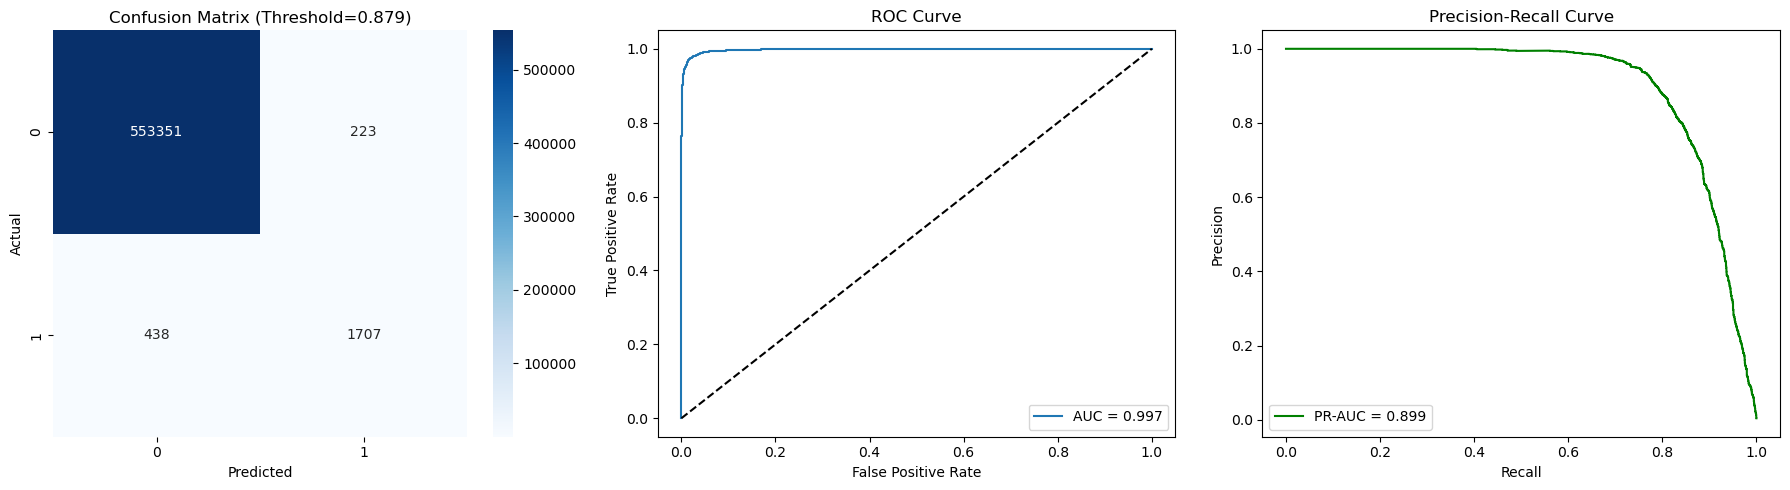

In [2]:
# ========================================================================
# 8. TEST ON NEW FILE (fraudTest.csv)
# ========================================================================
print("\n" + "="*60)
print("TESTING ON NEW FILE (fraudTest.csv)")
print("="*60)

test_file_path = 'fraudTest.csv'

try:
    # 8.1 Load Test Data
    print(f"Loading test data from {test_file_path}...")
    df_new_test = pd.read_csv(test_file_path)
    
    # 8.2 Preprocess Test Data
    # Lưu ý: Ta tái sử dụng hàm preprocess_data. 
    # Trong môi trường Production nghiêm ngặt, bạn nên lưu LabelEncoder từ bước train 
    # để transform cho test. Ở đây ta giả định các category (Gender, Job...) tương đồng.
    print("Preprocessing test data...")
    df_new_processed, _ = preprocess_data(df_new_test, is_train=False, label_encoders=label_encoders)
    
    # Tách X, y
    if 'is_fraud' in df_new_processed.columns:
        X_new = df_new_processed.drop('is_fraud', axis=1)
        y_new = df_new_processed['is_fraud']
    else:
        X_new = df_new_processed
        y_new = None
        print("Note: 'is_fraud' column not found in test data. Skipping evaluation metrics.")
    
    # Đảm bảo thứ tự cột giống hệt lúc train (quan trọng cho XGBoost/LightGBM)
    # Nếu thiếu cột nào (do drop), code sẽ báo lỗi hoặc cần xử lý thêm
    X_new = X_new[X_train.columns]
    
    # 8.3 Predict using Trained Model
    print("Predicting on new data...")
    y_new_proba = model.predict_proba(X_new)[:, 1]
    
    # 8.4 Evaluate using the OPTIMAL THRESHOLD found earlier
    if y_new is not None:
        print(f"Evaluating using saved threshold: {optimal_threshold:.4f}")
        evaluate_performance(y_new, y_new_proba, threshold=optimal_threshold)
    else:
        print("Predictions generated (y_new_proba).")
        
except FileNotFoundError:
    print(f"Warning: File {test_file_path} not found. Skipping external test.")
except Exception as e:
    print(f"An error occurred during testing: {e}")
    import traceback
    traceback.print_exc()


FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:
             feature  importance
                 amt    0.221468
   category_mean_amt    0.084772
            category    0.083789
                hour    0.077976
amt_vs_category_mean    0.074253
             amt_log    0.069427
                 age    0.061326
    card_trans_count    0.055501
       card_mean_amt    0.046274
            city_pop    0.044084


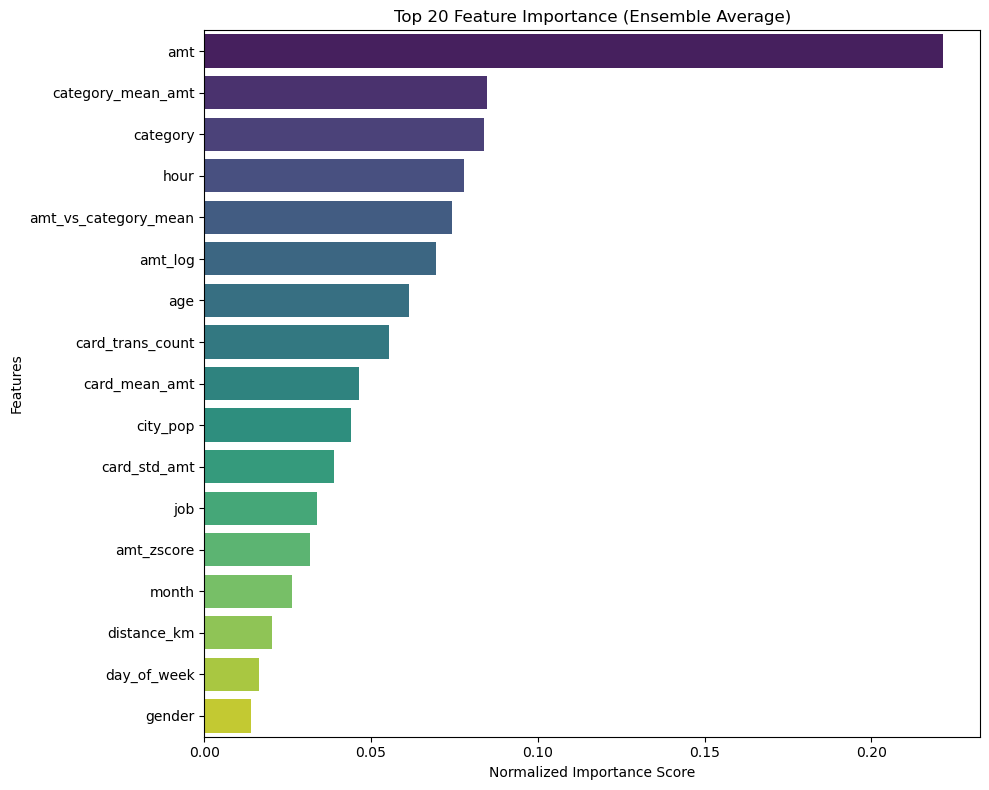

In [3]:
def plot_feature_importance(model, feature_names):
    """
    Trực quan hóa tầm quan trọng của các đặc trưng từ VotingClassifier
    bằng cách lấy trung bình từ các model con.
    """
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)

    # Lấy danh sách các model con đã được train
    estimators = model.estimators_
    
    importances_list = []
    
    for clf in estimators:
        # Kiểm tra xem model có thuộc tính feature_importances_ không
        if hasattr(clf, 'feature_importances_'):
            imp = clf.feature_importances_
            # Chuẩn hóa về thang đo 0-1 (vì CatBoost, LGBM có thể có thang đo khác nhau)
            if imp.sum() > 0:
                imp = imp / imp.sum()
            importances_list.append(imp)
            
    if not importances_list:
        print("Không thể trích xuất feature importance từ các model con.")
        return

    # Tính trung bình cộng độ quan trọng từ 3 model
    avg_importance = np.mean(importances_list, axis=0)
    
    # Tạo DataFrame để hiển thị
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': avg_importance
    })
    
    # Sắp xếp giảm dần
    fi_df = fi_df.sort_values(by='importance', ascending=False)
    
    # In ra Top 10
    print("Top 10 Most Important Features:")
    print(fi_df.head(10).to_string(index=False))
    
    # Vẽ biểu đồ
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=fi_df.head(20), palette='viridis')
    plt.title('Top 20 Feature Importance (Ensemble Average)')
    plt.xlabel('Normalized Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, X_train.columns)